# Bike Sharing Prediction

![title](images/bikes.png)

## 1. Context and objective


This notebook is our final project for the class [MAP546P - Python for Data Science](https://moodle.polytechnique.fr/course/view.php?id=6124).

The objective is to **forecast the use of the city bikeshare system** in Washington. It is part of a [Kaggle competition](https://www.kaggle.com/c/bike-sharing-demand#description).

<font color='red'>Les kernels dont on s'est inspiré (on pourra supprimer cette partie ensuite Nessi, c'était juste pour nous):</font>

In [21]:
# Importing libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sn

# Importing datasets
train = pd.read_csv('Desktop/data/train.csv')
test = pd.read_csv('Desktop/data/test.csv')

# Merging datasets
train["is_train"] = [1 for x in range(train.shape[0])]
test["is_train"] = [0 for x in range(test.shape[0])]
datasets = pd.concat([train, test], sort=False)
datasets = datasets.reset_index(drop = True)

## 2. Exploring the datasets (EDA)
### A. Structure of the datasets

In [22]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.0
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,1.0
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.0
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,1.0
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,1.0
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,1.0
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,1.0


The **training** dataset has **~11k rows**, and **12 columns**:
- **<font color='grey'>datetime</font>** - hourly date + timestamp (from 2011-01-01 to 2012-12-19)
- **<font color='grey'>season</font>**
    -  1 = spring
    - 2 = summer
    - 3 = fall
    - 4 = winter 
- **<font color='grey'>holiday</font>** - whether the day is considered a holiday
- **<font color='grey'>workingday</font>** - whether the day is neither a weekend nor holiday
- **<font color='grey'>weather</font>** 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- **<font color='grey'>temp</font>** - temperature in Celsius (from 0.82 to 40)
- **<font color='grey'>atemp</font>** - "feels like" temperature in Celsius (from 0.76 to 45.45)
- **<font color='grey'>humidity</font>** - relative humidity (from 0% to 100%)
- **<font color='grey'>windspeed</font>** - wind speed (from 0 to 57)
- **<font color='grey'>casual</font>** - number of non-registered user rentals initiated (from 0 to 367)
- **<font color='grey'>registered</font>** - number of registered user rentals initiated (from 0 to 886)
- **<font color='grey'>count</font>** - number of total rentals (from 1 to 977)

In [23]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,is_train
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.0
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157,0.0
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151,0.0
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000,0.0
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500,0.0
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400,0.0
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900,0.0
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600,0.0


The **test** dataset has **~6k** rows, and **the same columns**.

In [24]:
pd.DataFrame(data=datasets.isna().sum(), columns=["Number of NAs"]).transpose()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
Number of NAs,0,0,0,0,0,0,0,0,0,6493,6493,6493,0


Neither the training nor the test dataset has **missing entries**.

### B. Adding new variables

In [25]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1


We can create new variables from ```datetime```.

In [26]:
datasets["year"] = [int(datasets.datetime[x][0:4]) for x in range(datasets.shape[0])]
datasets["month"] = [int(datasets.datetime[x][5:7]) for x in range(datasets.shape[0])]
datasets["day"] = [int(datasets.datetime[x][8:10]) for x in range(datasets.shape[0])]
datasets["hour"] = [int(datasets.datetime[x][11:13]) for x in range(datasets.shape[0])]
datasets["weekday"] = [datetime.datetime.strptime(datasets.datetime[x][0:10], '%Y-%m-%d').weekday() for x in range(datasets.shape[0])]

In [28]:
train = datasets[datasets["is_train"] == 1]
test = datasets[datasets["is_train"] == 0]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,is_train,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,1,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,1,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,1,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,1,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,1,2011,1,1,4,5
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0.0,1.0,1.0,1,2011,1,1,5,5
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2.0,0.0,2.0,1,2011,1,1,6,5
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1.0,2.0,3.0,1,2011,1,1,7,5
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1.0,7.0,8.0,1,2011,1,1,8,5
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8.0,6.0,14.0,1,2011,1,1,9,5


### C. Visualisation
#### Outliers analysis

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Season'),
 Text(0.5, 1.0, 'Box Plot On Count Across Seasons')]

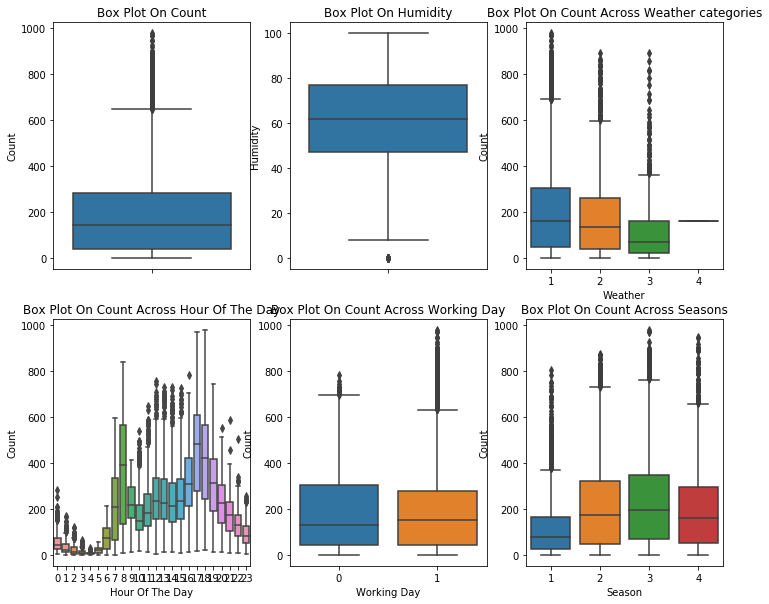

In [29]:
fig, axes = plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(12, 10)
sn.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=train,y="humidity",orient="v",ax=axes[0][1])
sn.boxplot(data=train,y="count",x="weather",orient="v",ax=axes[0][2])
sn.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])
sn.boxplot(data=train,y="count",x="season",orient="v",ax=axes[1][2])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(ylabel='Humidity',title="Box Plot On Humidity")
axes[0][2].set(xlabel='Weather', ylabel='Count',title="Box Plot On Count Across Weather categories")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[1][2].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Seasons")

The "count" variable contains outliers that skew the distribution towards right. We will try to investigate why it is so. --> could be linked to outliers of the "humidity" variable ? Few cases when 0 humidity --> high bike demand
General remarks to organize later:
- Few type 4 weather --> probably because it is 0 in this case (very bad weather) --> the average seems weird for this category
- Few spring data points
- Most of the outliers are from "Working Days".

Remplacer le graph température par le graph "heure", beaucoup plus intéressant.

In [30]:
#Let's remove the outliers
trainWithoutOutliers = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())] 
print("Number of outliers removed:", train.shape[0] - trainWithoutOutliers.shape[0])

Number of outliers removed: 147


/Users/inesvanagt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


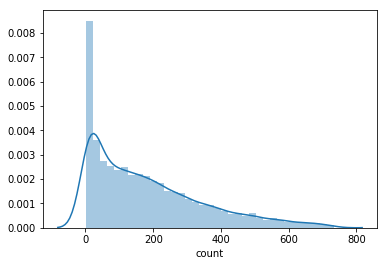

In [31]:
sn.distplot(trainWithoutOutliers['count'])
plt.show()

The distribution is indeed skewed, as seen in the outlier analysis (log scale in the model?)

#### Correlation analysis

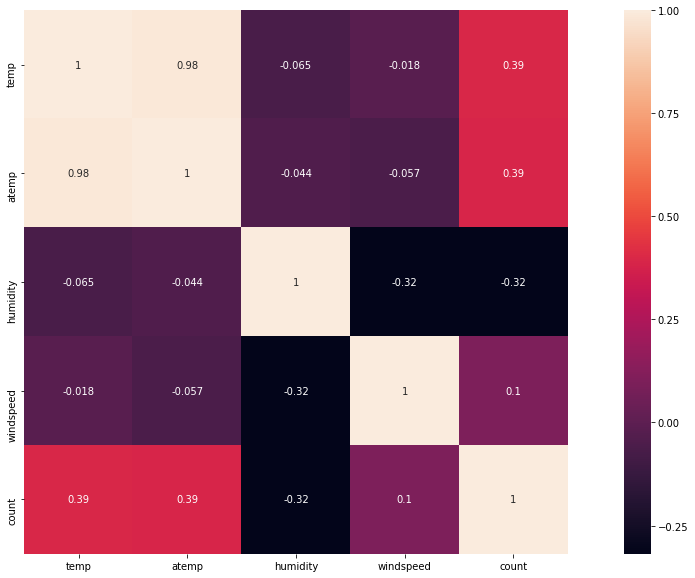

In [48]:
corr_matrix = train[["temp","atemp","humidity","windspeed","count"]].corr()
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corr_matrix, square=True,annot=True)

- temp and atemp too correlated --> we only keep one: atemp because we want to avoid multicollinearity in a regression
- windspeed seems to have a very low correlation with count
- humidity is negatively correlated with the count while temperature is positively correlated with the count (makes sense)

# Brainstorming
What kind of external data could we add?
- The hours of the sunset / sunrise to distinguish night time from day time

## Prediction